# Vinnytsia Coffee Culture

Asser Koskinen\
2025-01-09

## Abstract

How much do the coffee habits of inhabitants of a city tell us about their daily routine? Using a few simple data sources for the cozy city of Vinnytsia, in the heart of Ukraine, we find several interesting insights: A steadfast morning coffee break, few seasonal variations in coffee type popularity, a mid-week consumption dip, certain preference adjustments to weather, but overall loyalty to personal preference.

## Introduction (a bit of RegEx)

The Coffee Sales database by Yaroslav Isaienkov includes date, time, unique payment card identifiers, sales, and coffee type, for a coffee vending machine at a department store in the city Vinnytsia, Ukraine. The dataset has no missing values. We download and extract important information about the timing of purchase, to get a basic dataset to start with.

In [624]:
import pandas as pd
data = pd.read_csv('index.csv')

In [626]:
import re

# Convert date to datetime format
data['datetime'] = pd.to_datetime(data['datetime'])

# Extract month, weekday and hour from the datetime column
data['datetime'] = pd.to_datetime(data['datetime'])
data['month'] = data['datetime'].dt.month
data['weekday'] = data['datetime'].dt.weekday
# RegEx practice!
data['hour'] = data['datetime'].astype(str).apply(lambda x: int(re.search(r'\b(\d{2}):', x).group(1)))

## Sales by Hour of the Day (basic python)

In the heart of Ukraine, nestled in the charming city of Vinnytsia, coffee is not merely a caffeine fix – it’s an essential daily ritual, woven into the fabric of life. As the clock strikes *10 a.m.*, the air fills with the inviting aroma of freshly brewed coffee, signaling a moment of pause for the busy residents. This is their time to recharge, take a breath, and reconnect with themselves, their colleagues, and their surroundings.

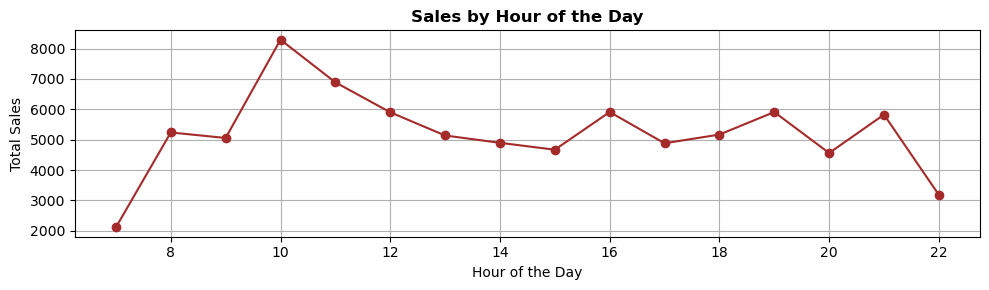

In [629]:
sales_by_hour = data.groupby('hour')['money'].sum()

# Plot
plt.figure(figsize=(10, 3))
plt.plot(sales_by_hour.index, sales_by_hour.values, marker='o', color='brown')

plt.title('Sales by Hour of the Day', fontweight='bold')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

# Close the connection
conn.close()

### Coffee Sales by Weekday (some SQL)

Yet, as the week unfolds, something curious happens: coffee consumption takes a slight dip in the middle of the workweek, hinting at the mysterious mid-week slump. An interesting question to investigate further would be what it is that could be at the root of this subtle coffee lull.

In [632]:
import sqlite3

# Create SQLite database
db = sqlite3.connect('index.db')

# Save the transformed data to the database
data.to_sql('coffee_sales', db, if_exists='replace', index=False)

2623

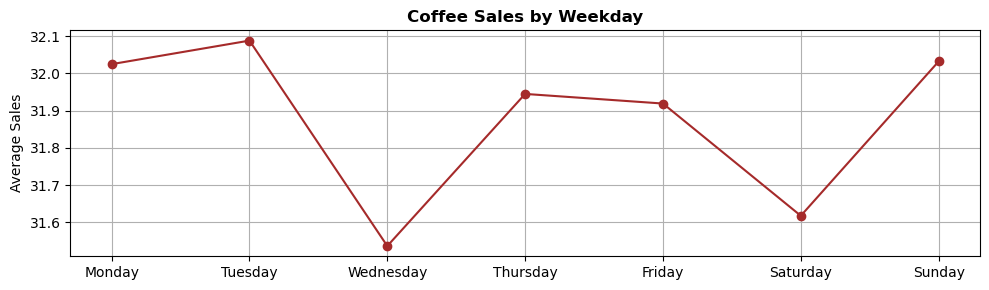

In [634]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the database
conn = sqlite3.connect('index.db')

# SQL query to calculate mean sales per weekday
query = """
SELECT weekday, AVG(money) AS avg_sales
FROM coffee_sales
GROUP BY weekday
ORDER BY weekday
"""

# Execute the query and load the result into a DataFrame
sales_per_weekday = pd.read_sql(query, conn)

# Map weekday numbers to names for better visualization
sales_per_weekday['weekday'] = sales_per_weekday['weekday'].map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
    4: 'Friday', 5: 'Saturday', 6: 'Sunday'
})

# Plot the results
plt.figure(figsize=(10, 3))
plt.plot(sales_per_weekday['weekday'], sales_per_weekday['avg_sales'], marker='o', color='brown')

# Plot styling
plt.title('Coffee Sales by Weekday', fontweight='bold')
plt.ylabel('Average Sales')
plt.xlabel('')
plt.grid(True)
plt.tight_layout()
plt.show()

# Close the connection
conn.close()

### Total Sales per Coffee Type per Month (some more SQL)

Year-round, *Caffè Latte* and *Americano with Milk* are the steadfast companions for those seeking warmth and serenity. These drinks are the heart of Vinnytsia’s coffee culture, the go-to choice for those who relish the simple pleasure of a good cup.

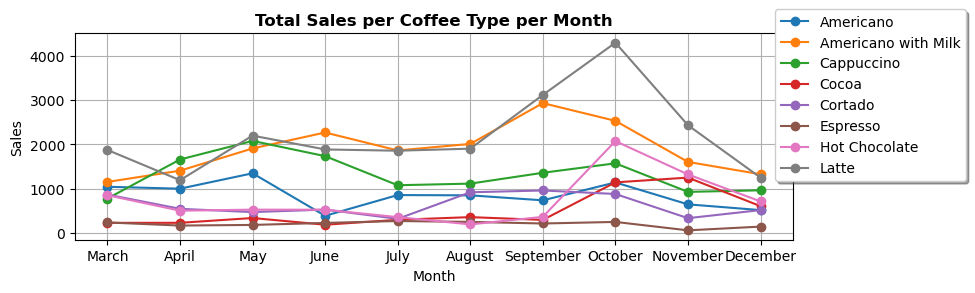

In [637]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect('index.db')

# Run the SQL query to calculate total sales per month
query = """
SELECT month, coffee_name, SUM(money) AS total_sales
FROM coffee_sales
GROUP BY month, coffee_name
ORDER BY month;
"""

# Read the query result into a DataFrame
sales_per_month_type = pd.read_sql_query(query, conn)

# Map month numbers to names for better visualization
sales_per_month_type['month'] = sales_per_month_type['month'].map({
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'
})

# Plot the results
plt.figure(figsize=(10, 3))
for coffee_type, group in sales_per_month_type.groupby('coffee_name'):
    plt.plot(group['month'], group['total_sales'], marker='o', label=coffee_type)

# Plot styling
plt.title('Total Sales per Coffee Type per Month', fontweight='bold')
plt.ylabel('Sales')
plt.xlabel('Month')
plt.xticks()
plt.legend(bbox_to_anchor = (1.25, 0.7), loc='center right', shadow=True)
plt.grid(True)
plt.tight_layout()
plt.show()

# Close the connection
conn.close()

### Average Temperature for Coffee Purchases (Web Scraping and API requests)

Then, as the temperature drops, a transformation sweeps across the city’s coffee scene. On chilly days, the familiar Caffè Latte and Americano are momentarily sidelined. In their place, *Hot Cocoa* and *Hot Chocolate* take center stage. These richer, more indulgent options offer not just warmth to the body but also a soul-soothing comfort against the cold. It’s a cozy treat, a moment of indulgence, as if the drink itself is a hug in a cup.

In [640]:
import requests
from bs4 import BeautifulSoup

# Scrape Wikipedia for latitude and longitude
url = "https://en.wikipedia.org/wiki/Vinnytsia"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
latitude_dms = soup.find('span', class_='latitude').text
longitude_dms = soup.find('span', class_='longitude').text

import re

# Convert DMS to decimal format
def dms_to_decimal(dms):
    match = re.match(r"(\d+)°(\d+)′([NSWE])", dms) #RegEx
    if not match:
        raise ValueError("Invalid DMS format")
    
    degrees = int(match.group(1))
    minutes = int(match.group(2))
    direction = match.group(3)

    decimal = degrees + minutes / 60

    # Apply negative sign for S (South) or W (West)
    if direction in ['S', 'W']:
        decimal = -decimal
    return decimal

latitude = dms_to_decimal(latitude_dms)
longitude = dms_to_decimal(longitude_dms)

In [641]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

# Setup Open-Meteo API request
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Prepare to add temperature data to the DataFrame
temperatures = []

# Query the weather API for each unique date in the data
for date in data['date'].unique():
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": date,
        "end_date": date,
        "daily": "temperature_2m_mean",
        "timezone": "Africa/Cairo"
    }
    response = openmeteo.weather_api(url, params=params)
    if response:
        temp = response[0].Daily().Variables(0).ValuesAsNumpy()[0]
        temperatures.append((date, temp))

# Create a temperature DataFrame
temp_df = pd.DataFrame(temperatures, columns=['date', 'temperature'])

In [643]:
# Merge temperature to original data
data = data.merge(temp_df, on='date', how='left')

# Save the updated DataFrame (if needed)
# data.to_csv('index_extended.csv', index=False)

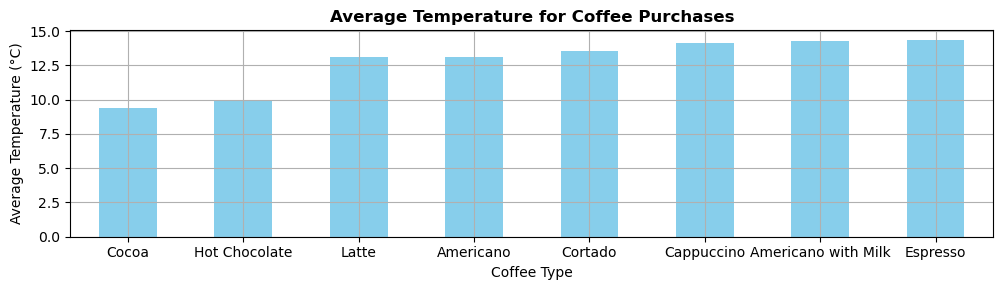

In [646]:
import matplotlib.pyplot as plt

# Group by coffee type and calculate average temperature for purchases
coffee_temp = data.groupby('coffee_name')['temperature'].mean().sort_values()

# Plot: Most Popular Coffee Types by Temperature
plt.figure(figsize=(10, 3))
coffee_temp.plot(kind='bar', color='skyblue')
plt.title('Average Temperature for Coffee Purchases', fontweight='bold')
plt.xlabel('Coffee Type')
plt.ylabel('Average Temperature (°C)')
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

### Repeat Customer Coffee Preferences (basic python)

Finally, amid all the change, one thing remains constant: loyalty. In Vinnytsia, coffee drinkers are creatures of habit. Most people stick to their favorite drink, rarely venturing into unfamiliar territory. Only a select few, the curious adventurers, dare to experiment with new flavors—perhaps just to break the monotony or to satisfy a fleeting craving. But for the majority, it’s the same comforting sip, day in and day out.

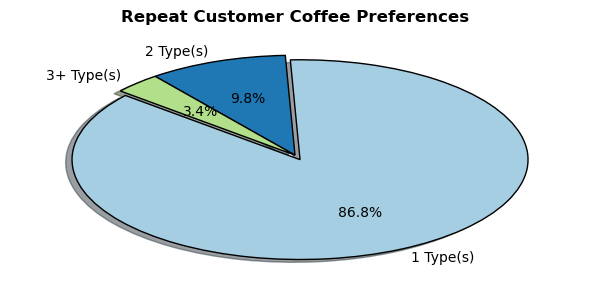

In [649]:
import pandas as pd
import matplotlib.pyplot as plt

# Sort data by customer (card) and datetime
data_sorted = data.sort_values(by=['card', 'datetime'])

# Calculate time difference between consecutive purchases by the same customer
data_sorted['time_diff'] = data_sorted.groupby('card')['datetime'].diff().dt.total_seconds() / 60

# Filter out consecutive purchases made within 30 minutes
filtered_data = data_sorted[(data_sorted['time_diff'].isna()) | (data_sorted['time_diff'] > 30)]

# Analyze distinct coffee types each customer buys
customer_coffee_preference = filtered_data.groupby(['card', 'coffee_name']).size().unstack(fill_value=0)
repeat_customers = customer_coffee_preference.gt(0).sum(axis=1)

# Group customers who purchased 4 or more types into a single category
preference_distribution = repeat_customers.value_counts()
preference_distribution = pd.concat([
    preference_distribution[preference_distribution.index <= 2],
    pd.Series(preference_distribution[preference_distribution.index >= 3].sum(), index=['3+'])
])

# Convert index to string for sorting
preference_distribution.index = preference_distribution.index.astype(str)
preference_distribution = preference_distribution.sort_index()

# Plot the pie chart
fig, ax = plt.subplots(figsize=(6, 3))
explode = [0.05 if i == '1' else 0 for i in preference_distribution.index]
ax.pie(
    preference_distribution,
    labels=[f'{i} Type(s)' for i in preference_distribution.index],
    autopct='%1.1f%%',
    startangle=140,
    explode=explode,
    shadow=True,
    colors=plt.cm.Paired.colors,
    wedgeprops={'edgecolor': 'black'}
)

# Adjust aspect ratio for the side-view effect
ax.set_aspect('auto')

# Styling
plt.title('Repeat Customer Coffee Preferences', fontweight='bold')
plt.tight_layout()
plt.show()

### Summary

In this cozy city, routine and ritual are intertwined. From the steadfast morning coffee break to the seasonal delights that warm hearts and hands, the coffee culture in Vinnytsia is a story of simplicity, comfort, and quiet joy found in every cup.

And so, as the clock strikes 10 a.m. once again, the people of Vinnytsia gather for their next fika, whether it’s a classic Caffè Latte or a steaming mug of Hot Chocolate on a brisk, wintry day. This ritual is timeless, a steadfast companion through the changing seasons, forever etched into the daily rhythm of life in the heart of Ukraine.

### Further Research

But as we observe this culture, some intriguing questions linger: What exactly drives the subtle shifts in coffee consumption throughout the seasons? Is it the opening hours of local cafés, the promotions on offer, or could there be a deeper, more intricate influence from Vinnytsia’s local culture? And what about the curious behavior of those who purchase multiple cups at once—are they enjoying a coffee break with a friend, perhaps buying a cup for someone else as an expression of friendship or generosity?

Living within the culture will, of course, offer the answers, but using the magnifying glass of data can show us patterns behind these behaviors can tell us a much more detailed story than we might first imagine. What will the data reveal about these rituals, habits, and the deeper currents of coffee culture in Vinnytsia? Could it even uncover something universal that transcends local boundaries?

There’s only one way to find out — by diving deeper into the data, one cup at a time.

### Data Sources

Coffee Sales (by Yaroslav Isaienkov): https://www.kaggle.com/datasets/ihelon/coffee-sales \
Coordinates: https://en.wikipedia.org/wiki/Vinnytsia \
Temperature: https://archive-api.open-meteo.com/v1/archive